# Modelling and Evaluation - Predicting SalePrice

## Objectives

* Fit and evaluate a regression model to predict the SalePrice to answer businness requirement 2. - "The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa."

## Inputs

* outputs/datasets/collection/HousePrices.csv
* Instructions on which variables to use for data cleaning and feature engineering. They can be found in the FeatureEngineering notebook.
## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and feature engineering pipeline
* Features importance plot

## CRISP-DM

* Modelling and evaluation.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-analysis'

# Load Data

Firstly we need to load the data we have been working with previously.

In [4]:
import numpy as np
import pandas as pd
df_raw_path = "outputs/datasets/collection/HousePrices.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


---

# ML Pipeline with all Data

## ML Pipeline for Data Cleaning and Feature Engineering

We need to import all the Data Cleaning and Feature Engineering libraries + some other libraries for feature scaling & selection. Finally We import some things for the ML algorithms.

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

print("Imports completed")

Imports completed


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Now we define the pipeline using the steps we took in the DataCleaning and FeatureEngineering notebooks.

In [6]:
def PipeLineDataCleaningFeatureEngineering(model):
    pipeline_base = Pipeline ([
        
        # Data Cleaning
        ("DropFeatures", DropFeatures (features_to_drop = ['BedroomAbvGr', '2ndFlrSF', 'LotFrontage', 'MasVnrArea'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median',
                                                variables='GarageYrBlt')),
        ("categorical_imputer", CategoricalImputer(imputation_method='frequent',
                                                  variables=['BsmtFinType1', 'GarageFinish'])),

        # Feature Engineering
        ("OrdinalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                          variables =['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ("LogTransformer", vt.LogTransformer(
                                variables = ['1stFlrSF', 'GrLivArea', 'LotArea', ])),
        ("PowerTransformer", vt.PowerTransformer(
                                    variables = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'TotalBsmtSF', ])),
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                                            variables = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'OpenPorchSF', ])),
        ("Winsorizor", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                  variables = ['GrLivArea'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method='spearman',
                                                              threshold=0.8, selection_method='variance', missing_values='ignore')),

        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base
    
print("Pipeline created!")

Pipeline created!


## ML Pipeline for Modelling and Hyperparameter Optimization



Custom class taken from Code Institute's Churnometer walkthrough project.

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipeLineDataCleaningFeatureEngineering(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

---

# Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['SalePrice'], axis=1),
                                        df['SalePrice'],
                                        test_size = 0.2,
                                        random_state = 0,
                                        )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


---

# Grid Search CV - Sklearn

We use standard hyper parameters to find the most suitable alogrithm.

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Let's check the results.

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.681961,0.8055,0.854296,0.062797
0,LinearRegression,0.761727,0.79413,0.836674,0.029553
4,AdaBoostRegressor,0.659639,0.764249,0.804636,0.054003
5,GradientBoostingRegressor,0.656244,0.763595,0.810296,0.056095
2,RandomForestRegressor,0.662549,0.732086,0.816271,0.058744
6,XGBRegressor,0.637822,0.67607,0.711843,0.027401
1,DecisionTreeRegressor,0.494971,0.581389,0.667303,0.065299


### Extensive search on most suitable model to find the best hyperparameter configuration

Based on initial performance metrics, including mean score, max score and standard deviation, the following models and assosiated parameters were defined. The configurations were obtained from scikit learn's website.

In [18]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}


params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3 ,15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1, 50],
                          },

    "LinearRegression":{},

    "RandomForestRegressor": {'model__n_estimators': [100, 50, 140],
                              'model__max_depth': [None, 4, 15],
                              'model__min_samples_split': [2, 50],
                              'model__min_samples_leaf': [1, 50],
                              'model__max_leaf_nodes': [None, 50],
                              },

    "GradientBoostingRegressor": {'model__n_estimators': [100, 50, 140],
                                  'model__learning_rate': [0.1, 0.01, 0.001], 
                                  'model__max_depth': [3, 15, None],
                                  'model__min_samples_split': [2, 50],
                                  'model__min_samples_leaf': [1, 50],
                                  'model__max_leaf_nodes': [None, 50],
    }
}

Extensive GridSearch CV

In [19]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
5,ExtraTreesRegressor,0.75828,0.810179,0.850495,0.037558,None,1,50,150,NaN,NaN
29,ExtraTreesRegressor,0.758499,0.810158,0.850428,0.037573,15,1,50,150,NaN,NaN
3,ExtraTreesRegressor,0.757929,0.809938,0.849539,0.03744,None,1,50,100,NaN,NaN
27,ExtraTreesRegressor,0.75781,0.8098,0.849539,0.03758,15,1,50,100,NaN,NaN
25,ExtraTreesRegressor,0.685226,0.807947,0.857428,0.062448,15,1,2,50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
266,GradientBoostingRegressor,0.034391,0.057557,0.076932,0.013694,3,1,2,50,50,0.001
272,GradientBoostingRegressor,0.040587,0.056537,0.068844,0.009235,3,50,2,50,50,0.001
275,GradientBoostingRegressor,0.040587,0.056537,0.068844,0.009235,3,50,50,50,50,0.001
260,GradientBoostingRegressor,0.040587,0.056537,0.068844,0.009235,3,50,2,50,None,0.001


## Determine the best model among the options

### ExtraTreesRegressor

In [21]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for the model.

In [22]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 150}

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Define the best clf pipeline

In [23]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['BedroomAbvGr', '2ndFlrSF',
                                                'LotFrontage', 'MasVnrArea'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['GarageYrBlt'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('OrdinalEncoder',
                 OrdinalEncoder(encoding_method=...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                      

## Assess Feature Importance

We calculate and display the feature importances of the model stored in the best_regressor_pipeline variable.
The following code cell code apapted from Code Institute's Scikit-Learn Unit 6 lesson.

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']


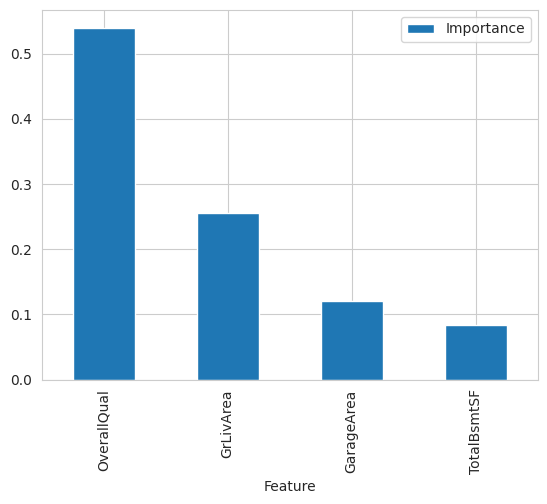

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 9
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                       .transform(X_train)
                                       .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# Creating a DataFrame to display feature importance.
df_feature_importance = (pd.DataFrame(data={
            'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
            'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
    )

# Most important features statement and plot.
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluation on Train and Test Sets

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluating importance

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 20661.124
Mean Squared Error: 1020429152.546
Root Mean Squared Error: 31944.157


* Test Set
R2 Score: 0.766
Mean Absolute Error: 22444.239
Mean Squared Error: 1615979749.081
Root Mean Squared Error: 40199.251




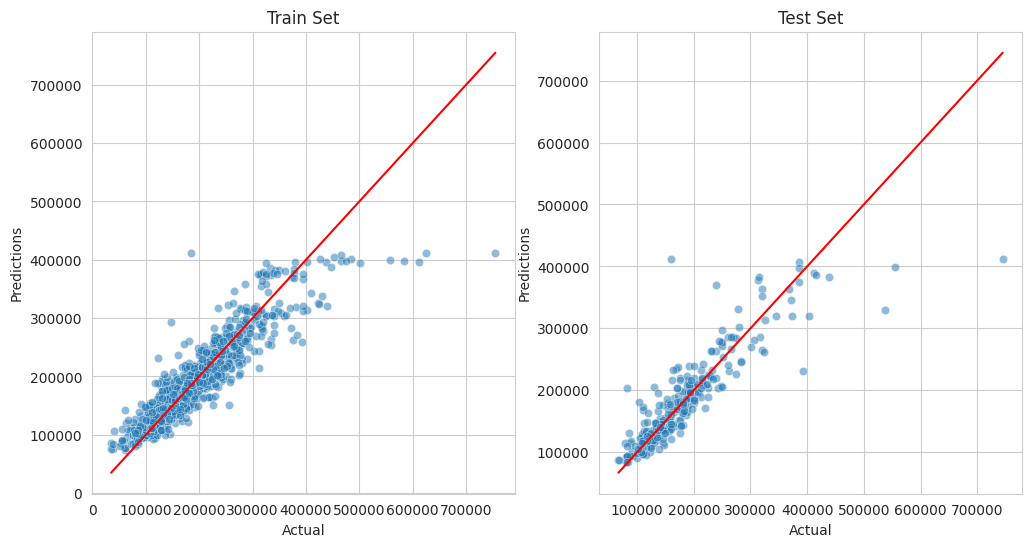

In [27]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)